# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [25]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
print(pd.__version__)
# magic word for producing visualizations in notebook
%matplotlib inline
!curl -O https://raw.githubusercontent.com/udacity/workspaces-student-support/master/jupyter/workspace_utils.py

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

0.23.3
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1554  100  1554    0     0   4332      0 --:--:-- --:--:-- --:--:--  7809


'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [26]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';')


In [27]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# azdias
csv_name='Udacity_AZDIAS_Subset'
nr = len(azdias)
nc = len(azdias.columns)
print('Dataset: {}, number rows: {}, number columns: {}'.format(csv_name,nr,nc))

# feature summary file
csv_name='AZDIAS_Feature_Summary'
nr = len(feat_info)
nc = len(feat_info.columns)
print('Dataset: {}, number rows: {}, number columns: {}'.format(csv_name,nr,nc))

azdias.head()

Dataset: Udacity_AZDIAS_Subset, number rows: 891221, number columns: 85
Dataset: AZDIAS_Feature_Summary, number rows: 85, number columns: 4


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [28]:
print(feat_info.columns)
feat_info.head()

Index(['attribute', 'information_level', 'type', 'missing_or_unknown'], dtype='object')


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [29]:
# Identify missing or unknown data values and convert them to NaNs.
columns = azdias.columns

def get_nan_values(c):
    summary_row = feat_info.missing_or_unknown[feat_info.attribute==c].values
    summary_row = summary_row[0].replace('[', '')
    summary_row = summary_row.replace(']', '')
    return summary_row

def is_digit(n):
    try:
        int(n)
        return True
    except ValueError:
        return  False
    
def replace_nan(value):
        
    if(is_digit(value)):

        value=int(value)
        azdias[c].replace(to_replace=float(value),value=np.nan,inplace=True) 

    azdias[c].replace(to_replace=value,value=np.nan,inplace=True) 
    
for c in columns:
    
    nan_values=get_nan_values(c)
     
    if len(nan_values)==0:
        continue
    elif len(nan_values)==1:
        replace_nan(nan_values)
    else:
        nan_values=nan_values.split(',')
        for j in nan_values:
            replace_nan(j)
            

azdias.head()            

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

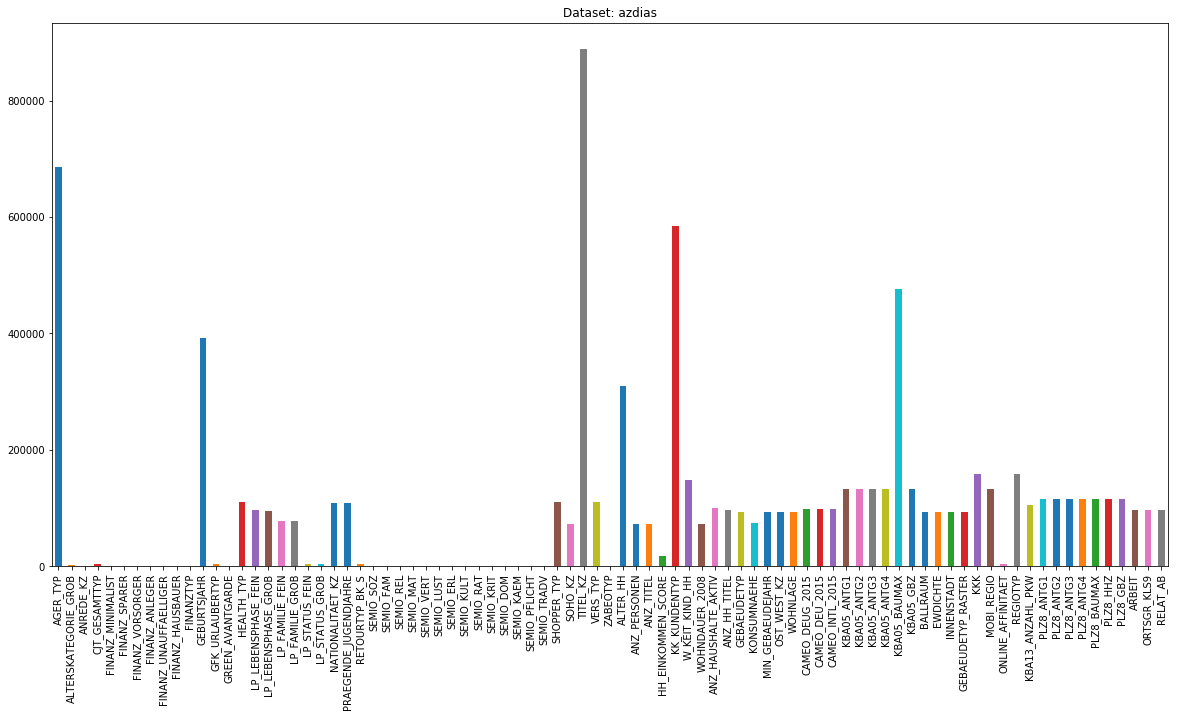

In [30]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

#T[True] - transpose and keep the True column.
azdias_nulls = azdias.apply(lambda x: x.isnull().value_counts()).T[True]
#vc_nulls.hist(ax=) # if you want a histogram of these counts
# or if you wanted to plot the null count of each column as a bar
azdias_nulls.plot(kind = 'bar',figsize=(20,10),title='Dataset: azdias')


In [31]:
# Investigate patterns in the amount of missing data in each column.
print("Columns                 #A Missing (%)")
colums = azdias.columns
lazdias=len(azdias)

for c in colums:

    valueA = sum(azdias[c].isna())
    valueAPer = (valueA/lazdias)*100
    
    s="{:23s}|{:7d}({:.2f}%)".format(c, valueA, valueAPer)
    if(valueAPer>=30):
        print(s,'<-----')
    else:
        print(s)



Columns                 #A Missing (%)
AGER_TYP               | 685843(76.96%) <-----
ALTERSKATEGORIE_GROB   |   2881(0.32%)
ANREDE_KZ              |      0(0.00%)
CJT_GESAMTTYP          |   4854(0.54%)
FINANZ_MINIMALIST      |      0(0.00%)
FINANZ_SPARER          |      0(0.00%)
FINANZ_VORSORGER       |      0(0.00%)
FINANZ_ANLEGER         |      0(0.00%)
FINANZ_UNAUFFAELLIGER  |      0(0.00%)
FINANZ_HAUSBAUER       |      0(0.00%)
FINANZTYP              |      0(0.00%)
GEBURTSJAHR            | 392318(44.02%) <-----
GFK_URLAUBERTYP        |   4854(0.54%)
GREEN_AVANTGARDE       |      0(0.00%)
HEALTH_TYP             | 111196(12.48%)
LP_LEBENSPHASE_FEIN    |  97632(10.95%)
LP_LEBENSPHASE_GROB    |  94572(10.61%)
LP_FAMILIE_FEIN        |  77792(8.73%)
LP_FAMILIE_GROB        |  77792(8.73%)
LP_STATUS_FEIN         |   4854(0.54%)
LP_STATUS_GROB         |   4854(0.54%)
NATIONALITAET_KZ       | 108315(12.15%)
PRAEGENDE_JUGENDJAHRE  | 108164(12.14%)
RETOURTYP_BK_S         |   4854(0.54%)
SEMI

In [32]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
labels_drop=['AGER_TYP','TITEL_KZ','GEBURTSJAHR','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX']
azdias=azdias.drop(labels=labels_drop, axis=1)
feat_info=feat_info.loc[feat_info.attribute.isin(labels_drop)==False]


#### Discussion 1.1.2: Assess Missing Data in Each Column

Columns from both datasets have the similar missing data rates (data is not missing at random).
The 5 columns in the "labels_drop" variable (['AGER_TYP','TITEL_KZ','GEBURTSJAHR','KK_KUNDENTYP','KBA05_BAUMAX']) present more that 44% of missing data and were removed from the datasets. The customer dataset seems to have twice the missing data of the azdias dataset in relative terms. 


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

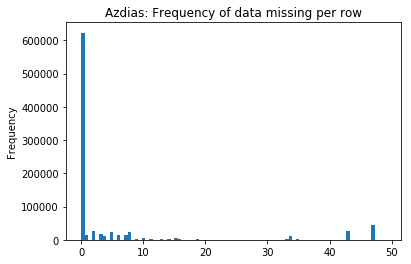

In [33]:
# How much data is missing in each row of the dataset?

azdias.isna().sum(axis=1).sort_values(ascending=False)

azdias.isna().sum(axis=1).plot(kind='hist',bins=85,title='Azdias: Frequency of data missing per row')

In [34]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
nan_row_counts_azdias=azdias.isna().sum(axis=1)
azdias_complete=azdias.loc[nan_row_counts_azdias<=20,:]
azdias_missing=azdias.loc[nan_row_counts_azdias>20,:]
azdias_complete.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [35]:
azdias_missing.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ALTERSKATEGORIE_GROB
ANREDE_KZ
CJT_GESAMTTYP
FINANZ_MINIMALIST
FINANZ_SPARER


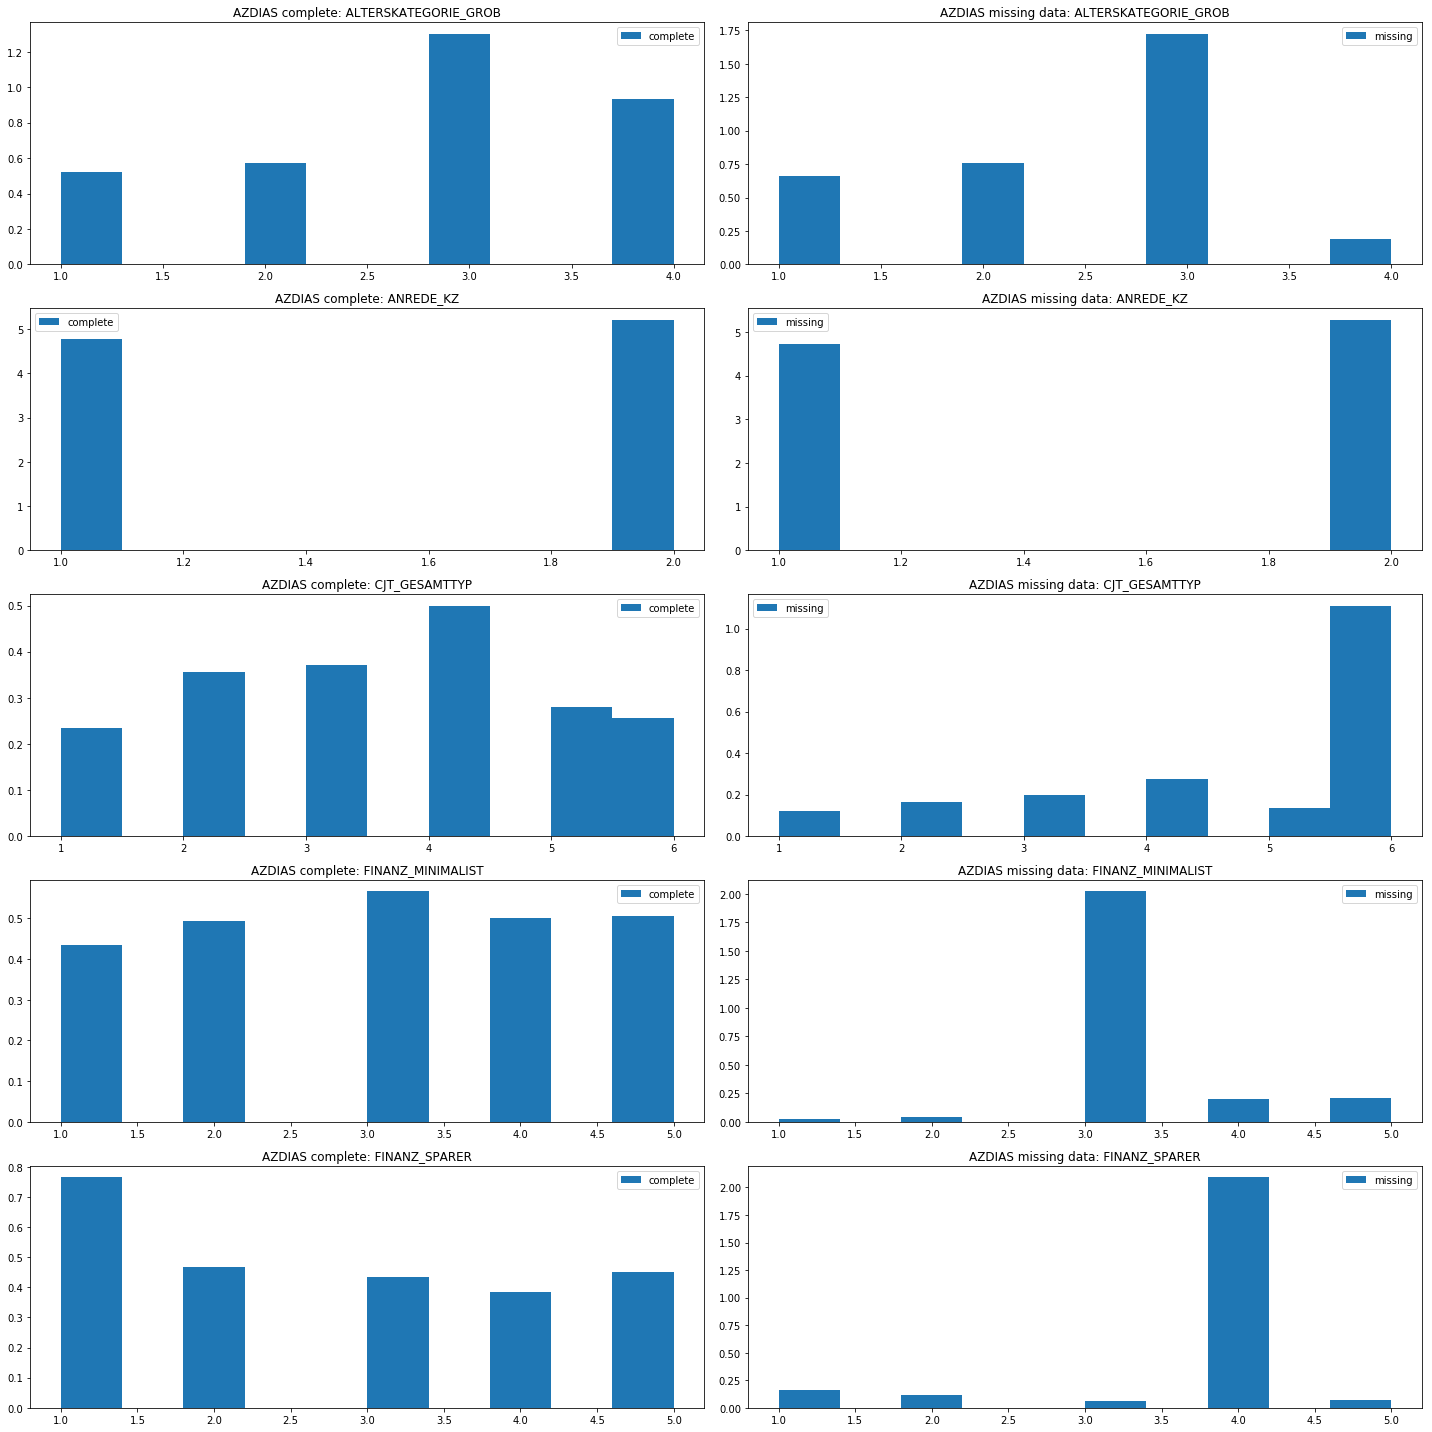

In [36]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def get_histograms(normalised=True):
    fig_a,ax_a = plt.subplots(5,2,figsize=(20,20))
    colums=azdias_complete.columns
    count = 0
    normed=normalised
    for c in colums[:5]:

        print(c)
        #sns.histplot(data=azdias_aux, x=c, hue="missing", multiple="dodge", shrink=.8,stat="probability", discrete=True)

        ax_a[count, 0].hist(azdias_complete[c].dropna(),label='complete',normed=normed)
        ax_a[count, 0].set_title('AZDIAS complete: '+c)
        ax_a[count, 0].legend()    
        ax_a[count, 1].hist(azdias_missing[c].dropna(),label='missing',normed=normed)
        ax_a[count, 1].set_title('AZDIAS missing data: '+c)
        ax_a[count, 1].legend()    

        count+=1



    plt.tight_layout()
    plt.show()
get_histograms(normalised=True)

ALTERSKATEGORIE_GROB
ANREDE_KZ
CJT_GESAMTTYP
FINANZ_MINIMALIST
FINANZ_SPARER


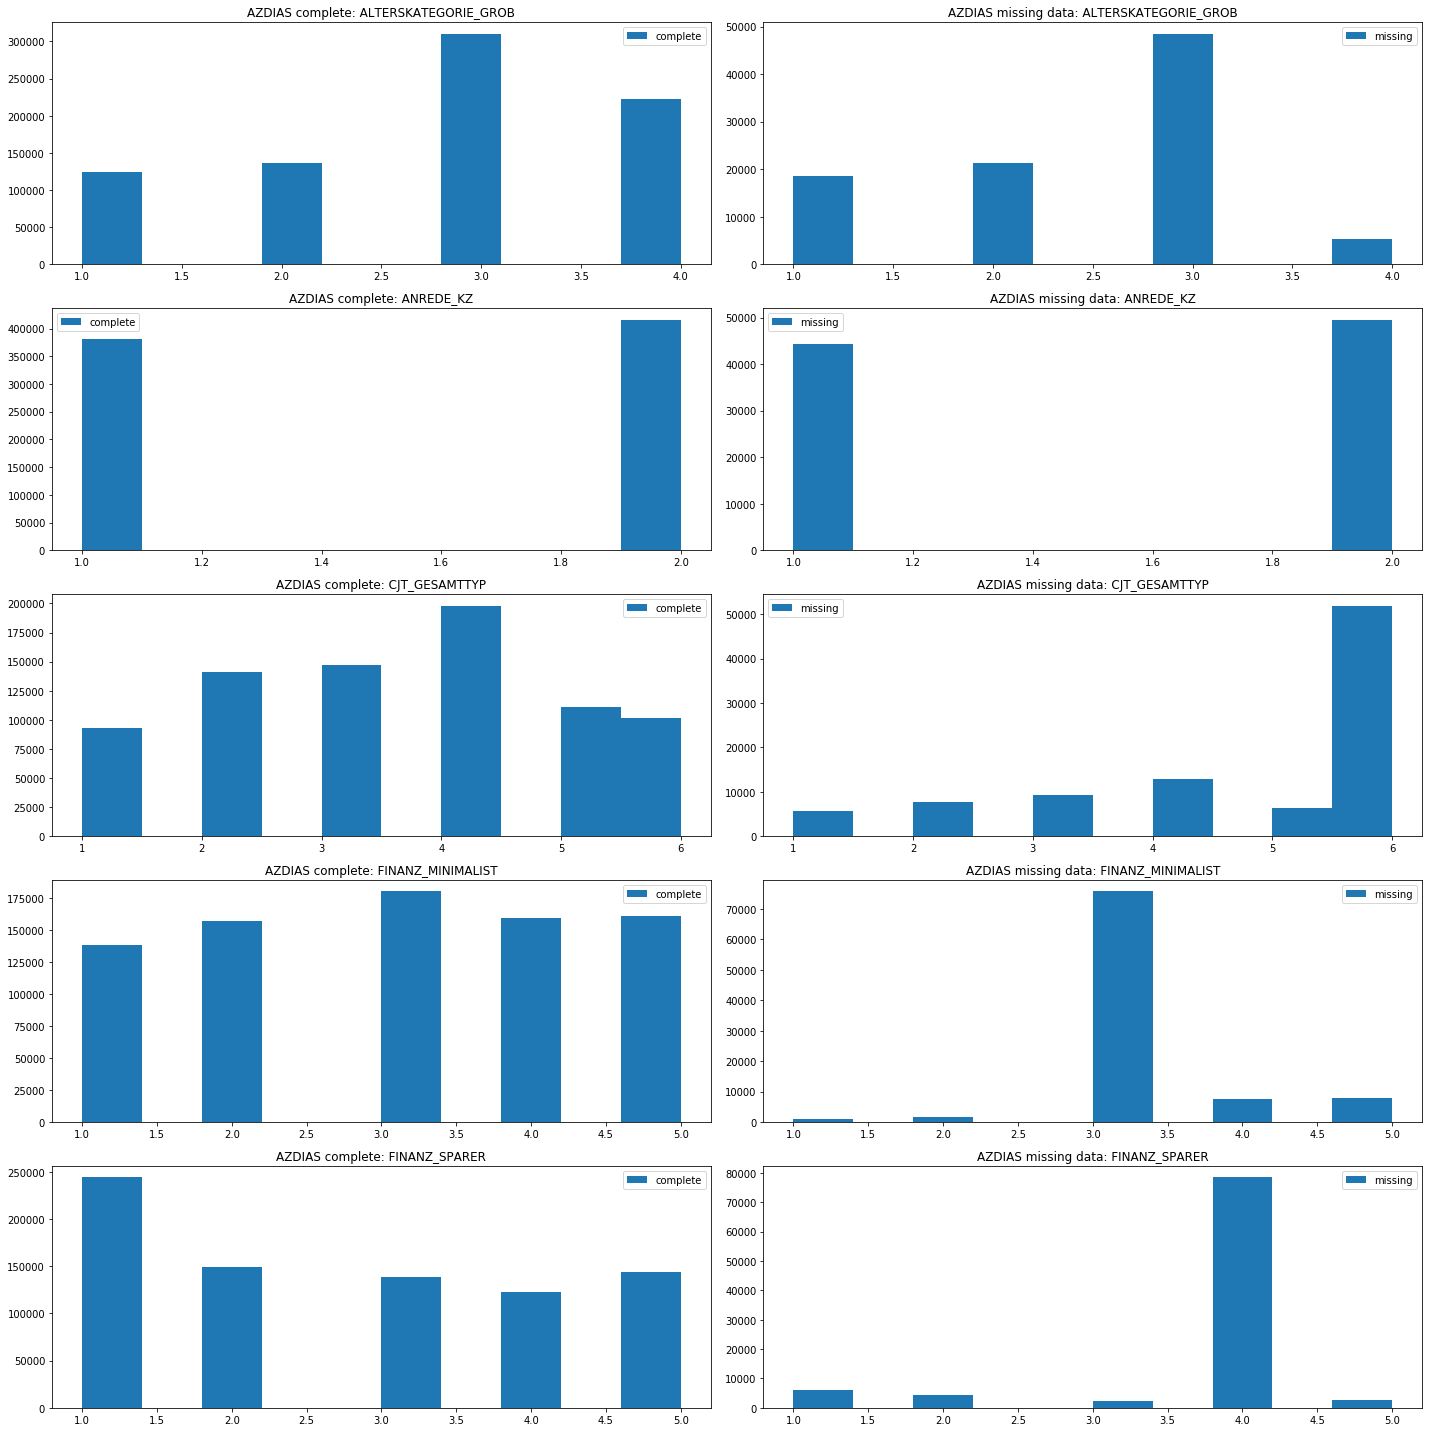

In [37]:
get_histograms(normalised=False)

#### Discussion 1.1.3: Assess Missing Data in Each Row

From observing the histogram showing the Frequency of missing data per row, rows with more than 20 missing values were deemed incomplete, and the remainder were deemed "complete".

Observing the distribution of the first 5 columns [AGER_TYP, ALTERSKATEGORIE_GROB, ANREDE_KZ,CJT_GESAMTTYP, FINANZ_MINIMALIST], apart from ANREDE_KZ (gender), the distributions of the rows with incomplete data are different from those with more complete data.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [38]:
# How many features are there of each data type?
feat_info.groupby(['type']).count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,18,18,18
mixed,6,6,6
numeric,6,6,6
ordinal,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [39]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

azdias_cat_dic_unique={}
customer_cat_dic_unique={}

categorical_columns = feat_info.attribute.loc[feat_info.type=='categorical']

for c in categorical_columns:

    azdias_cat_dic_unique[c]=azdias[c].dropna().unique()

azdias_cat_dic_unique

{'ANREDE_KZ': array([1, 2]),
 'CJT_GESAMTTYP': array([ 2.,  5.,  3.,  4.,  1.,  6.]),
 'FINANZTYP': array([4, 1, 6, 5, 2, 3]),
 'GFK_URLAUBERTYP': array([ 10.,   1.,   5.,  12.,   9.,   3.,   8.,  11.,   4.,   2.,   7.,
          6.]),
 'GREEN_AVANTGARDE': array([0, 1]),
 'LP_FAMILIE_FEIN': array([  2.,   5.,   1.,  10.,   7.,  11.,   3.,   8.,   4.,   6.,   9.]),
 'LP_FAMILIE_GROB': array([ 2.,  3.,  1.,  5.,  4.]),
 'LP_STATUS_FEIN': array([  1.,   2.,   3.,   9.,   4.,  10.,   5.,   8.,   6.,   7.]),
 'LP_STATUS_GROB': array([ 1.,  2.,  4.,  5.,  3.]),
 'NATIONALITAET_KZ': array([ 1.,  3.,  2.]),
 'SHOPPER_TYP': array([ 3.,  2.,  1.,  0.]),
 'SOHO_KZ': array([ 1.,  0.]),
 'VERS_TYP': array([ 2.,  1.]),
 'ZABEOTYP': array([3, 5, 4, 1, 6, 2]),
 'GEBAEUDETYP': array([ 8.,  1.,  3.,  2.,  6.,  4.,  5.]),
 'OST_WEST_KZ': array(['W', 'O'], dtype=object),
 'CAMEO_DEUG_2015': array(['8', '4', '2', '6', '1', '9', '5', '7', '3'], dtype=object),
 'CAMEO_DEU_2015': array(['8A', '4C', '2A', '6B'

In [40]:
# Re-encode categorical variable(s) to be kept in the analysis.

# remove redundant categorical variables.

labels_drop=['LP_FAMILIE_FEIN','CAMEO_DEU_2015','LP_LEBENSPHASE_GROB','LP_STATUS_FEIN']
azdias=azdias.drop(labels=labels_drop, axis=1)
feat_info=feat_info.loc[feat_info.attribute.isin(labels_drop)==False]


# turn binary variables into 0,1
binary_preprocess = ['ANREDE_KZ','GREEN_AVANTGARDE','VERS_TYP']

for c in binary_preprocess:

    azdias[c]=azdias[c]-1
    
#categorical=['OST_WEST_KZ','CAMEO_DEU_2015']
categorical=feat_info.loc[(feat_info.type=='categorical') & (feat_info.attribute.isin(binary_preprocess)==False) & (feat_info.attribute.isin(azdias.columns))].attribute.values


azdias=pd.get_dummies(azdias,columns=categorical,drop_first=True)


#### Discussion 1.2.1: Re-Encode Categorical Features

Those with 2 numbers were transformed to [0,1] when required (i.e. if they were encoded with only [1,2], they were converted to [0,1]).The remaining categorical columns were converted into dummy variables (and the original columns dropped).

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [41]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# - -1: unknown
# -  0: unknown
# -  1: 40s - war years (Mainstream, E+W)
# -  2: 40s - reconstruction years (Avantgarde, E+W)
# -  3: 50s - economic miracle (Mainstream, E+W)
# -  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
# -  5: 60s - economic miracle (Mainstream, E+W)
# -  6: 60s - generation 68 / student protestors (Avantgarde, W)
# -  7: 60s - opponents to the building of the Wall (Avantgarde, E)
# -  8: 70s - family orientation (Mainstream, E+W)
# -  9: 70s - peace movement (Avantgarde, E+W)
# - 10: 80s - Generation Golf (Mainstream, W)
# - 11: 80s - ecological awareness (Avantgarde, W)
# - 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
# - 13: 80s - Swords into ploughshares (Avantgarde, E)
# - 14: 90s - digital media kids (Mainstream, E+W)
# - 15: 90s - ecological awareness (Avantgarde, E+W)

def age_band(x):
    if x <= 2:
        return 1
    elif x<=4:
        return 2
    elif x<=7:
        return 3
    elif x<=9:
        return 4
    elif x<=13:
        return 5
    elif x<=15:
        return 6

def movement(x):
    if x in [1,3,5,8,10,12,14]:
        return 0
    elif x in [2,4,6,7,9,11,13,15]:
        return 1
    

c='PRAEGENDE_JUGENDJAHRE'
azdias['decade'] = azdias[c].apply(lambda x: age_band(x) if pd.isnull(x)==False else x)
azdias['movement'] = azdias[c].apply(lambda x: movement(x) if pd.isnull(x)==False else x)
azdias['movement'].head()

0    NaN
1    0.0
2    1.0
3    0.0
4    0.0
Name: movement, dtype: float64

In [42]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
### 4.3. CAMEO_INTL_2015
#German CAMEO: Wealth / Life Stage Typology, mapped to international code
# - -1: unknown
# - 11: Wealthy Households - Pre-Family Couples & Singles
# - 12: Wealthy Households - Young Couples With Children
# - 13: Wealthy Households - Families With School Age Children
# - 14: Wealthy Households - Older Families &  Mature Couples
# - 15: Wealthy Households - Elders In Retirement
# - 21: Prosperous Households - Pre-Family Couples & Singles
# - 22: Prosperous Households - Young Couples With Children
# - 23: Prosperous Households - Families With School Age Children
# - 24: Prosperous Households - Older Families & Mature Couples
# - 25: Prosperous Households - Elders In Retirement
# - 31: Comfortable Households - Pre-Family Couples & Singles
# - 32: Comfortable Households - Young Couples With Children
# - 33: Comfortable Households - Families With School Age Children
# - 34: Comfortable Households - Older Families & Mature Couples
# - 35: Comfortable Households - Elders In Retirement
# - 41: Less Affluent Households - Pre-Family Couples & Singles
# - 42: Less Affluent Households - Young Couples With Children
# - 43: Less Affluent Households - Families With School Age Children
# - 44: Less Affluent Households - Older Families & Mature Couples
# - 45: Less Affluent Households - Elders In Retirement
# - 51: Poorer Households - Pre-Family Couples & Singles
# - 52: Poorer Households - Young Couples With Children
# - 53: Poorer Households - Families With School Age Children
# - 54: Poorer Households - Older Families & Mature Couples
# - 55: Poorer Households - Elders In Retirement
# - XX: unknown

azdias['wealth']=azdias['CAMEO_INTL_2015'].apply(lambda x: str(x)[0] if pd.isnull(x)==False else np.nan)
azdias['life_stage']=azdias['CAMEO_INTL_2015'].apply(lambda x: str(x)[1] if pd.isnull(x)==False else np.nan)
azdias[['CAMEO_INTL_2015','wealth','life_stage']].head()


,CAMEO_INTL_2015,wealth,life_stage
0,NaN,NaN,NaN
1,51,5,1
2,24,2,4
3,12,1,2
4,43,4,3


In [43]:
mixed_columns = feat_info.attribute.loc[(feat_info.type=='mixed') & (feat_info.attribute.isin(['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE'])==False)]
print(mixed_columns)
azdias[mixed_columns].head()

15    LP_LEBENSPHASE_FEIN
56               WOHNLAGE
79            PLZ8_BAUMAX
Name: attribute, dtype: object


,LP_LEBENSPHASE_FEIN,WOHNLAGE,PLZ8_BAUMAX
0,15.0,NaN,NaN
1,21.0,4.0,1.0
2,3.0,2.0,1.0
3,NaN,7.0,1.0
4,32.0,3.0,2.0


In [44]:
mixed_label='LP_LEBENSPHASE_FEIN'

LP_LEBENSPHASE_FEIN_DIC={}
dic_features = {1: 'single low-income earners of younger age',
2: 'single low-income earners of middle age',
3: 'single average earners of younger age',
4: 'single average earners of middle age',
5: 'single low-income earners of advanced age',
6: 'single low-income earners at retirement age',
7: 'single average earners of advanced age',
8: 'single average earners at retirement age',
9: 'single independent persons',
10: 'wealthy single homeowners',
11: 'single homeowners of advanced age',
12: 'single homeowners at retirement age',
13: 'single top earners of higher age',
14: 'low-income and average earner couples of younger age',
15: 'low-income earner couples of higher age',
16: 'average earner couples of higher age',
17: 'independent couples',
18: 'wealthy homeowner couples of younger age',
19: 'homeowner couples of higher age',
20: 'top earner couples of higher age',
21: 'single parent low-income earners',
22: 'single parent average earners',
23: 'single parent high-income earners',
24: 'low-income earner families',
25: 'average earner families',
26: 'independent families',
27: 'homeowner families',
28: 'top earner families',
29: 'low-income earners of younger age from multiperson households',
30: 'average earners of younger age from multiperson households',
31: 'low-income earners of higher age from multiperson households',
32: 'average earners of higher age from multiperson households',
33: 'independent persons of younger age from multiperson households',
34: 'homeowners of younger age from multiperson households',
35: 'top earners of younger age from multiperson households',
36: 'independent persons of higher age from multiperson households',
37: 'homeowners of advanced age from multiperson households',
38: 'homeowners at retirement age from multiperson households',
39: 'top earners of middle age from multiperson households',
40: 'top earners at retirement age from multiperson households'}

LP_LEBENSPHASE_FEIN_DIC.update(dic_features)

feature_single=["single"]
feature_multiperson=["multiperson"]
feature_family=["couples","families"]
family_status=[feature_single,feature_family,feature_multiperson]

feature_high_income=['top earner','wealthy']
feature_average_income=['average','homeowners','independent']
feature_low_income=['low-income']
feature_wealth=[feature_low_income,feature_average_income,feature_high_income]

age_group_old = ['higher age','advanced age','retirement age']
age_group_adult = ['families','single parent','middle age','independent couples']
age_group_young = ['younger age']
age_group=[age_group_young,age_group_adult,age_group_old]

def getEncoding(x,features):
        
    for i in range(len(features)):
       
        for w in features[i]:
           
            if w in x:
               
                return i


print(LP_LEBENSPHASE_FEIN_DIC[azdias['LP_LEBENSPHASE_FEIN'][1]])

getEncoding(LP_LEBENSPHASE_FEIN_DIC[azdias['LP_LEBENSPHASE_FEIN'][1]],family_status)
getEncoding(LP_LEBENSPHASE_FEIN_DIC[azdias['LP_LEBENSPHASE_FEIN'][1]],feature_wealth)
getEncoding(LP_LEBENSPHASE_FEIN_DIC[azdias['LP_LEBENSPHASE_FEIN'][1]],age_group)

azdias['feature_family_status']=azdias['LP_LEBENSPHASE_FEIN'].apply(lambda x: getEncoding(LP_LEBENSPHASE_FEIN_DIC[x],family_status) if pd.isnull(x)==False else np.nan)
azdias['feature_wealth']=azdias['LP_LEBENSPHASE_FEIN'].apply(lambda x: getEncoding(LP_LEBENSPHASE_FEIN_DIC[x],feature_wealth) if pd.isnull(x)==False else np.nan)
azdias['feature_age_group']=azdias['LP_LEBENSPHASE_FEIN'].apply(lambda x:  getEncoding(LP_LEBENSPHASE_FEIN_DIC[x],age_group) if pd.isnull(x)==False else np.nan)

azdias[['LP_LEBENSPHASE_FEIN','feature_family_status','feature_wealth','feature_age_group']].head()

single parent low-income earners


,LP_LEBENSPHASE_FEIN,feature_family_status,feature_wealth,feature_age_group
0,15.0,1.0,0.0,2.0
1,21.0,0.0,0.0,1.0
2,3.0,0.0,1.0,0.0
3,NaN,NaN,NaN,NaN
4,32.0,2.0,1.0,2.0


In [45]:
azdias=pd.get_dummies(azdias,columns=['feature_family_status','feature_wealth','feature_age_group'],drop_first=True)


#### Discussion 1.2.2: Engineer Mixed-Type Features

##### Which ones did you keep?

WOHNLAGE, PLZ8_BAUMAX were kept the same.
PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015 were ketp.
LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB encoded the same information, threfore the first, encoding fine-grain information, was kept (LP_LEBENSPHASE_GROB was dropped).

#### Which ones did you drop?

LP_FAMILIE_FEIN and LP_FAMILIE_GROB are redundant, the second is a coarse scale of the first and was kept, as we already have many features in our dataset.

CAMEO_DEUG_2015 and CAMEO_DEU_2015 are redundant, the first is a coarse scale of the second and was kept, as we already have many features in our dataset, and the second seemed to add too much detail to the analysis.

LP_STATUS_GROB and LP_STATUS_FEIN are redundant. I kept that with a coarser scale(LP_STATUS_GROB), and dropped LP_STATUS_FEIN.


##### and what engineering steps did you perform?
The following features were created from the fields that were kept:

- PRAEGENDE_JUGENDJAHRE=  decade and movement (2 features), as there were not enough levels to represent the location patterns.
- CAMEO_INTL_2015 = Wealth / Life Stage Typology (2 features), as described above.
- LP_LEBENSPHASE_FEIN = encodes Life stage, wealth and age group (3 features). 


the preprocessing method can be reviewed in the cells above.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [46]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [47]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias.drop(columns=['LP_LEBENSPHASE_FEIN','PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'],inplace=True)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [2]:
%%time

        
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
print(pd.__version__)
# magic word for producing visualizations in notebook
%matplotlib inline
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';')

def get_nan_values(c):
    summary_row = feat_info.missing_or_unknown[feat_info.attribute==c].values
    summary_row = summary_row[0].replace('[', '')
    summary_row = summary_row.replace(']', '')
    return summary_row

def is_digit(n):
    try:
        int(n)
        return True
    except ValueError:
        return  False
    
def replace_nan(df,column,value):
        
    if(is_digit(value)):

        value=int(value)
        df[column].replace(to_replace=float(value),value=np.nan,inplace=True) 
     
    df[column].replace(to_replace=value,value=np.nan,inplace=True) 
    
    return df


def getEncoding(x,features):

    for i in range(len(features)):

        for w in features[i]:

            if w in x:

                return i


def age_band(x):
    if x <= 2:
        return 1
    elif x<=4:
        return 2
    elif x<=7:
        return 3
    elif x<=9:
        return 4
    elif x<=13:
        return 5
    elif x<=15:
        return 6

def movement(x):
    if x in [1,3,5,8,10,12,14]:
        return 0
    elif x in [2,4,6,7,9,11,13,15]:
        return 1
    
            
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # remove columns (moved here to optimise)
    labels_drop=['AGER_TYP','TITEL_KZ','GEBURTSJAHR','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX']

    df=df.drop(labels=labels_drop, axis=1)
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    columns = df.columns

    for c in columns:

        nan_values=get_nan_values(c)

        if len(nan_values)==0:
            continue
        elif len(nan_values)==1:
            df=replace_nan(df,c,nan_values)
        else:
            nan_values=nan_values.split(',')
            for j in nan_values:
                df=replace_nan(df,c,j)
            
    
    # remove selected columns and rows, ...
    # to optmise i've removed columns before 
    
    
    # remove rows
    nan_row_counts=df.isna().sum(axis=1)
    df=df.loc[nan_row_counts<=20,:]
    
    # select, re-encode, and engineer column values.
    
    # remove reduntant columns
    labels_drop=['LP_FAMILIE_FEIN','CAMEO_DEU_2015','LP_LEBENSPHASE_GROB','LP_STATUS_FEIN']
    df=df.drop(labels=labels_drop, axis=1)
    
    
    df_raw=df.copy()
    # binary
    binary_preprocess = ['ANREDE_KZ','VERS_TYP',]
    #binary_preprocess = ['ANREDE_KZ','GREEN_AVANTGARDE','VERS_TYP',]

    for c in binary_preprocess:

        df[c]=df[c]-1
       
    
    # categorical
    categorical=feat_info.loc[(feat_info.type=='categorical') & (feat_info.attribute.isin(binary_preprocess)==False) & (feat_info.attribute.isin(df.columns))].attribute.values

    df=pd.get_dummies(df,columns=categorical,drop_first=True)
    
    # mixed
    c='PRAEGENDE_JUGENDJAHRE'
    df['decade'] = df[c].apply(lambda x: age_band(x) if pd.isnull(x)==False else x)
    df['movement'] = df[c].apply(lambda x: movement(x) if pd.isnull(x)==False else x)
    
    c='CAMEO_INTL_2015'
    df['wealth']=df[c].apply(lambda x: str(x)[0] if pd.isnull(x)==False else np.nan)
    df['life_stage']=df[c].apply(lambda x: str(x)[1] if pd.isnull(x)==False else np.nan)
    
    
    LP_LEBENSPHASE_FEIN_DIC={}
    dic_features = {1: 'single low-income earners of younger age',
    2: 'single low-income earners of middle age',
    3: 'single average earners of younger age',
    4: 'single average earners of middle age',
    5: 'single low-income earners of advanced age',
    6: 'single low-income earners at retirement age',
    7: 'single average earners of advanced age',
    8: 'single average earners at retirement age',
    9: 'single independent persons',
    10: 'wealthy single homeowners',
    11: 'single homeowners of advanced age',
    12: 'single homeowners at retirement age',
    13: 'single top earners of higher age',
    14: 'low-income and average earner couples of younger age',
    15: 'low-income earner couples of higher age',
    16: 'average earner couples of higher age',
    17: 'independent couples',
    18: 'wealthy homeowner couples of younger age',
    19: 'homeowner couples of higher age',
    20: 'top earner couples of higher age',
    21: 'single parent low-income earners',
    22: 'single parent average earners',
    23: 'single parent high-income earners',
    24: 'low-income earner families',
    25: 'average earner families',
    26: 'independent families',
    27: 'homeowner families',
    28: 'top earner families',
    29: 'low-income earners of younger age from multiperson households',
    30: 'average earners of younger age from multiperson households',
    31: 'low-income earners of higher age from multiperson households',
    32: 'average earners of higher age from multiperson households',
    33: 'independent persons of younger age from multiperson households',
    34: 'homeowners of younger age from multiperson households',
    35: 'top earners of younger age from multiperson households',
    36: 'independent persons of higher age from multiperson households',
    37: 'homeowners of advanced age from multiperson households',
    38: 'homeowners at retirement age from multiperson households',
    39: 'top earners of middle age from multiperson households',
    40: 'top earners at retirement age from multiperson households'}

    LP_LEBENSPHASE_FEIN_DIC.update(dic_features)

    feature_single=["single"]
    feature_multiperson=["multiperson"]
    feature_family=["couples","families"]
    family_status=[feature_single,feature_family,feature_multiperson]

    feature_high_income=['top earner','wealthy']
    feature_average_income=['average','homeowners','independent']
    feature_low_income=['low-income']
    feature_wealth=[feature_low_income,feature_average_income,feature_high_income]

    age_group_old = ['higher age','advanced age','retirement age']
    age_group_adult = ['families','single parent','middle age','independent couples']
    age_group_young = ['younger age']
    age_group=[age_group_young,age_group_adult,age_group_old]
    
    
    df['feature_family_status']=df['LP_LEBENSPHASE_FEIN'].apply(lambda x: getEncoding(LP_LEBENSPHASE_FEIN_DIC[x],family_status) if pd.isnull(x)==False else np.nan)
    df['feature_wealth']=df['LP_LEBENSPHASE_FEIN'].apply(lambda x: getEncoding(LP_LEBENSPHASE_FEIN_DIC[x],feature_wealth) if pd.isnull(x)==False else np.nan)
    df['feature_age_group']=df['LP_LEBENSPHASE_FEIN'].apply(lambda x:  getEncoding(LP_LEBENSPHASE_FEIN_DIC[x],age_group) if pd.isnull(x)==False else np.nan)
    
    df=pd.get_dummies(df,columns=['feature_family_status','feature_wealth','feature_age_group'],drop_first=True)
    df.drop(columns=['LP_LEBENSPHASE_FEIN','PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'],inplace=True)
    # Return the cleaned dataframe.
    
    return df,df_raw

print("size before cleaning:",len(azdias)," rows")
print("size before cleaning:",len(azdias.columns)," columns")

azdias,azdias_raw=clean_data(azdias)
print("size after cleaning:",len(azdias_raw)," rows")
print("size after cleaning:",len(azdias_raw.columns)," columns")
print("size after cleaning:",len(azdias.columns)," pre-processed columns")

0.23.3
size before cleaning: 891221  rows
size before cleaning: 85  columns
size after cleaning: 797426  rows
size before cleaning: 75  columns
size before cleaning: 125  pre-processed columns
CPU times: user 32.5 s, sys: 4.74 s, total: 37.3 s
Wall time: 1min 9s


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [3]:
%%time
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer
from workspace_utils import active_session

with active_session():

    imp = Imputer(missing_values='NaN', strategy='median', axis=1)
    imp.fit(azdias)
    azdias_aux=imp.transform(azdias)
    azdias_complete=pd.DataFrame(azdias_aux,index=azdias.index, columns=azdias.columns)

#azdias_complete=azdias.dropna(axis=0)



CPU times: user 13.4 s, sys: 5.93 s, total: 19.3 s
Wall time: 2min 58s


In [4]:
feat_info_ordinal=feat_info.loc[(feat_info.attribute.isin(azdias_complete.columns)) & (feat_info.type=='ordinal')]
feat_info_numeric=feat_info.loc[(feat_info.attribute.isin(azdias_complete.columns)) & (feat_info.type=='numeric')]


In [5]:
ordinal_columns_list=feat_info_ordinal.attribute.values
numeric_columns_list=feat_info_numeric.attribute.values
print(numeric_columns_list)


['ANZ_PERSONEN' 'ANZ_TITEL' 'ANZ_HAUSHALTE_AKTIV' 'ANZ_HH_TITEL'
 'MIN_GEBAEUDEJAHR' 'KBA13_ANZAHL_PKW']


In [6]:
%%time
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler

azdias_complete_scaled = azdias_complete.copy()

columns_list=np.concatenate((numeric_columns_list,ordinal_columns_list,np.array(['decade','wealth','life_stage'])))

scaler = StandardScaler().fit(azdias_complete[columns_list])

azdias_aux=scaler.transform(azdias_complete[columns_list])  

azdias_complete_scaled[columns_list] = azdias_aux


#azdias_norm=pd.DataFrame(azdias_aux,index=azdias.index, columns=azdias.columns)




CPU times: user 1.66 s, sys: 1.84 s, total: 3.51 s
Wall time: 3.61 s


### Discussion 2.1: Apply Feature Scaling

The median value of each column was used to replace missing data in the respective column.
This was done via "Imputer(missing_values='NaN', strategy='median', axis=1)". Axis=1, ensures the imputation is done per column. The median was selected such that the missing values would be replaced by that most representative (50th centile) of that particular column.
one-hot-encoded and binary variables were not scaled.
Numeric and ordinal variables and the pre-processed variables ['decade','wealth','life_stage'] were scaled with the standard scaler.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [7]:
%%time
# Apply PCA to the data.
import numpy as np
from sklearn.decomposition import PCA

def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca



pca,X_pca = do_pca(None, azdias_complete_scaled)



CPU times: user 51.9 s, sys: 4.21 s, total: 56.1 s
Wall time: 2min 14s


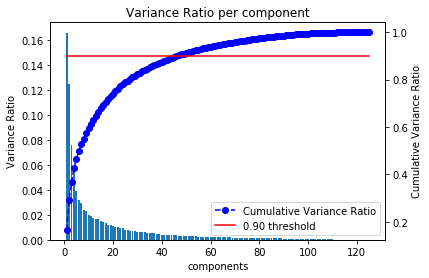

number of components explaining 90% of the variability in the data: 49  components


In [21]:
# Investigate the variance accounted for by each principal component.

# print(pca.explained_variance_)
# print(pca.explained_variance_ratio_)
# print(pca.explained_variance_ratio_.cumsum())

## sum of squared errors vs number of cluters plot
fig, ax1 = plt.subplots()
ax1.bar(list(range(1,len(pca.explained_variance_ratio_)+1)),pca.explained_variance_ratio_,label='Variance Ratio');
ax1.set_xlabel('components');
ax1.set_ylabel('Variance Ratio');
ax1.set_title('Variance Ratio per component'); 

ax2 = ax1.twinx()
ax2.plot(list(range(1,len(pca.explained_variance_ratio_)+1)),pca.explained_variance_ratio_.cumsum(), linestyle='--', marker='o', color='b',label='Cumulative Variance Ratio');
ax2.plot(list(range(1,len(pca.explained_variance_ratio_)+1)),np.repeat(0.9, len(pca.explained_variance_ratio_)), linestyle='-', color='r',label='0.90 threshold');

ax2.set_ylabel('Cumulative Variance Ratio');
plt.legend()        
plt.show()

n_components=sum(pca.explained_variance_ratio_.cumsum()<=0.91)
print("number of components explaining 90% of the variability in the data:",n_components, " components")

In [15]:
%%time
# Re-apply PCA to the data while selecting for number of components to retain.
#n_components=sum(pca.explained_variance_ratio_.cumsum()<=0.91) # selection number of components retaining 90%
azdias_pca_model_small,azdias_reduced = do_pca(0.90, azdias_complete_scaled)



CPU times: user 52.6 s, sys: 4.8 s, total: 57.4 s
Wall time: 2min 40s


### Discussion 2.2: Perform Dimensionality Reduction

Looking at the cumulative sum of the explained variance ratio (Figure "Variance Ratio percomponent"), 49 components were selected as they explain 90% of the variability in the data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

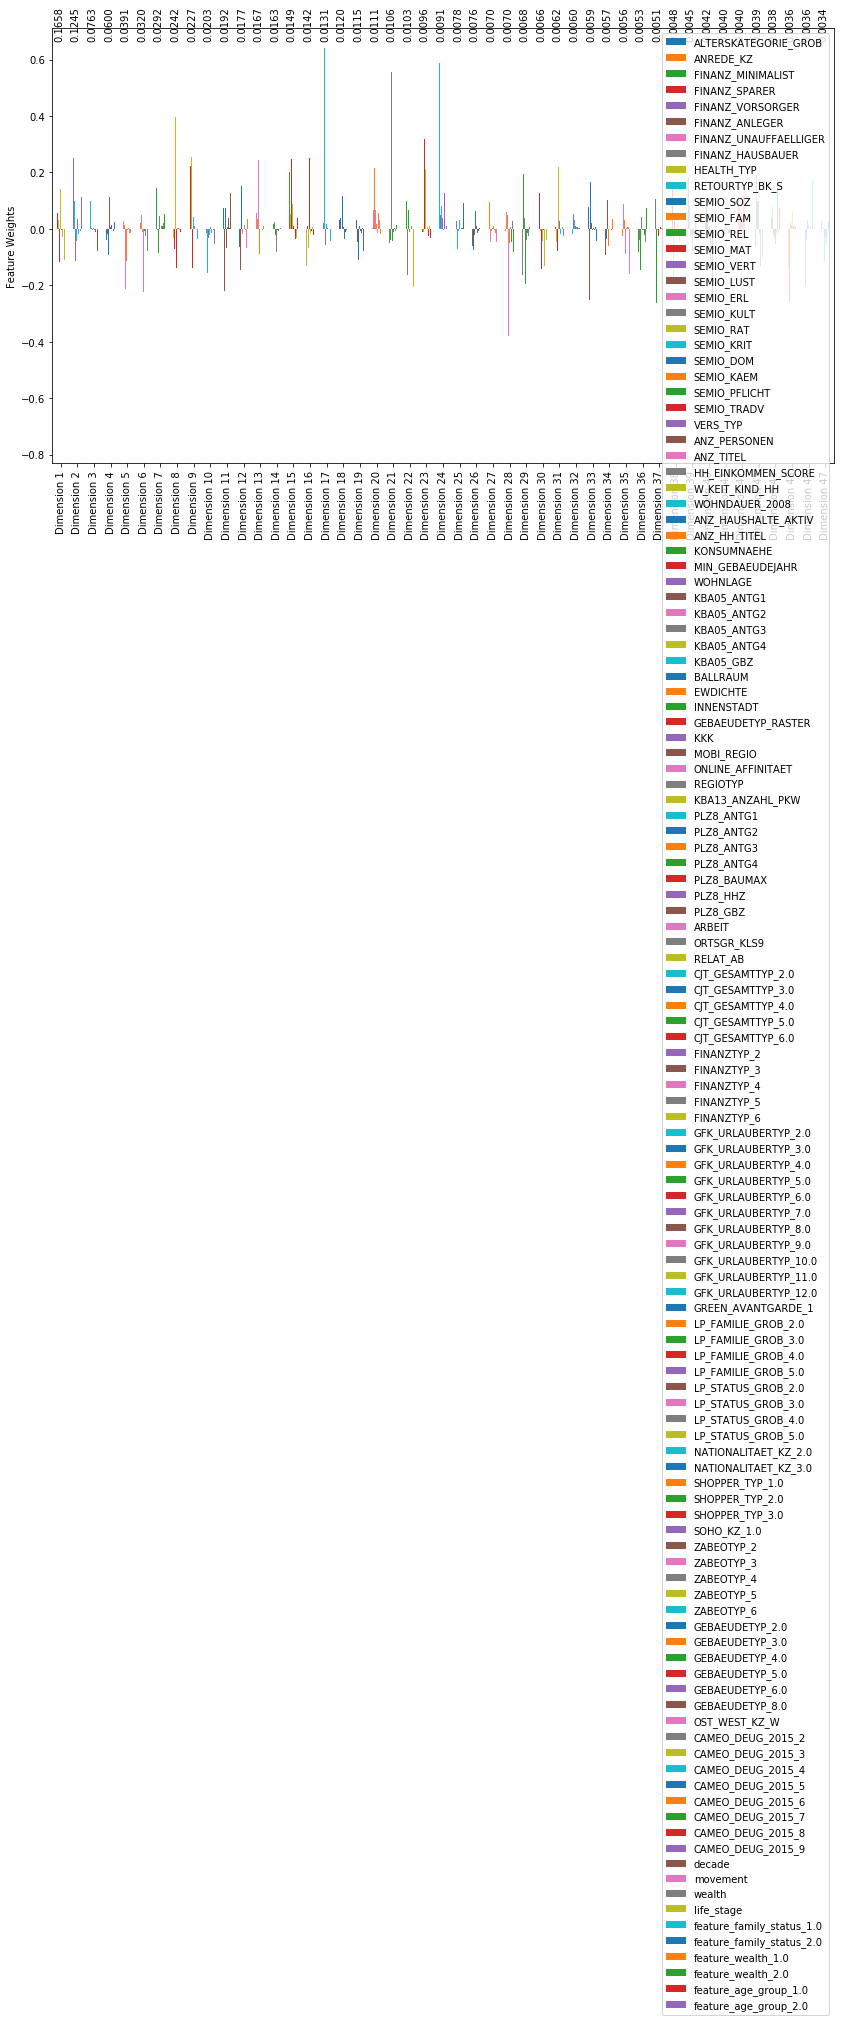

In [22]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
# function from the PCA Mini Project - Solution - udacity course.

def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=90)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "%.4f"%(ev),rotation=90)

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)


PCA_RESULTS=pca_results(azdias_complete_scaled, azdias_pca_model_small)


In [23]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
row_1=PCA_RESULTS.iloc[0].sort_values(ascending=False)
print('Column                   Weight')
print(row_1)

Column                   Weight
PLZ8_BAUMAX              0.3226
PLZ8_ANTG3               0.2267
PLZ8_ANTG4               0.2236
ORTSGR_KLS9              0.2177
EWDICHTE                 0.2142
wealth                   0.1902
HH_EINKOMMEN_SCORE       0.1750
Explained Variance       0.1658
FINANZ_HAUSBAUER         0.1520
ARBEIT                   0.1471
PLZ8_ANTG2               0.1467
RELAT_AB                 0.1416
KBA05_ANTG4              0.1408
ANZ_HAUSHALTE_AKTIV      0.1300
KBA05_ANTG3              0.1241
FINANZ_SPARER            0.1032
SEMIO_PFLICHT            0.0771
REGIOTYP                 0.0769
SEMIO_REL                0.0748
SEMIO_RAT                0.0633
SEMIO_FAM                0.0553
SEMIO_MAT                0.0552
SEMIO_TRADV              0.0542
KKK                      0.0478
decade                   0.0461
SEMIO_KULT               0.0458
PLZ8_HHZ                 0.0455
FINANZ_UNAUFFAELLIGER    0.0454
SEMIO_KAEM               0.0450
CAMEO_DEUG_2015_9        0.0411
        

In [24]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

row_2=PCA_RESULTS.iloc[1].sort_values(ascending=False)
print('Column                   Weight')
print(row_2)

Column                   Weight
ALTERSKATEGORIE_GROB     0.2731
FINANZ_VORSORGER         0.2497
SEMIO_ERL                0.2256
SEMIO_LUST               0.1938
RETOURTYP_BK_S           0.1650
Explained Variance       0.1245
feature_age_group_2.0    0.1144
FINANZ_MINIMALIST        0.1111
W_KEIT_KIND_HH           0.1020
ZABEOTYP_3               0.1012
SEMIO_KRIT               0.0972
SEMIO_KAEM               0.0864
FINANZ_HAUSBAUER         0.0801
PLZ8_BAUMAX              0.0726
WOHNDAUER_2008           0.0710
ORTSGR_KLS9              0.0663
EWDICHTE                 0.0660
PLZ8_ANTG3               0.0577
SEMIO_DOM                0.0536
PLZ8_ANTG4               0.0534
ARBEIT                   0.0461
RELAT_AB                 0.0453
CJT_GESAMTTYP_2.0        0.0433
PLZ8_ANTG2               0.0431
FINANZTYP_2              0.0362
SHOPPER_TYP_3.0          0.0360
KBA05_ANTG4              0.0359
ANZ_HAUSHALTE_AKTIV      0.0354
wealth                   0.0347
FINANZTYP_5              0.0341
        

In [25]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

row_3=PCA_RESULTS.iloc[2].sort_values(ascending=False)
print('Column                   Weight')
print(row_3)

Column                   Weight
SEMIO_VERT               0.3692
SEMIO_SOZ                0.2840
SEMIO_FAM                0.2756
SEMIO_KULT               0.2622
FINANZ_MINIMALIST        0.1723
RETOURTYP_BK_S           0.1000
FINANZ_VORSORGER         0.0942
SEMIO_REL                0.0920
W_KEIT_KIND_HH           0.0793
Explained Variance       0.0763
SEMIO_MAT                0.0714
ALTERSKATEGORIE_GROB     0.0635
SEMIO_LUST               0.0553
PLZ8_BAUMAX              0.0494
FINANZTYP_5              0.0467
feature_age_group_2.0    0.0388
WOHNDAUER_2008           0.0344
ORTSGR_KLS9              0.0340
EWDICHTE                 0.0321
PLZ8_ANTG4               0.0289
PLZ8_ANTG3               0.0272
ARBEIT                   0.0241
SHOPPER_TYP_1.0          0.0225
GREEN_AVANTGARDE_1       0.0217
RELAT_AB                 0.0214
movement                 0.0204
PLZ8_ANTG2               0.0167
LP_STATUS_GROB_5.0       0.0140
feature_wealth_2.0       0.0133
ANZ_HAUSHALTE_AKTIV      0.0122
        

### Discussion 2.3: Interpret Principal Components

#### First principal Component

- Positive terms 
PLZ8_BAUMAX (0.3226, Most common building type within the PLZ8 region)

PLZ8_ANTG3 (0.2267, Number of 6-10 family houses in the PLZ8 region)

PLZ8_ANTG4 (0.2236, Number of 10+ family houses in the PLZ8 region)

- Negative terms

MOBI_REGIO (-0.2065, Movement patterns)

PLZ8_ANTG1 (-0.2106, Number of 1-2 family houses in the PLZ8 region)

WOHNLAGE (-0.2386, Neighborhood quality (or rural flag))

the prominent terms from the 1st principal component seem to be related with the location and type of house-assets of the population.  
Comparing positive vs negative terms, it seems that people that live in bigger houses are anti-correlated with those leaving in smaller houses perhaps with higher movement patterns (i.e. changing houses/locations more often).

#### Second principal component: 

- Positive terms:

ALTERSKATEGORIE_GROB (0.2731, Estimated age based on given name analysis)

FINANZ_VORSORGER (0.2497, Financial typology, be prepared)

SEMIO_ERL (0.2256, Personality typology, event-oriented)


- Negative terms:

Decade (-0.2452, Age band)

FINANZ_SPARER (-0.2571, Financial typology, money-saver)

SEMIO_REL (-0.2588, Personality typology, religious)

the prominent terms from the 2nd principal component seem to be related with the Finantial topology and age and "mindset" of the population.
Comparing positive vs negative terms, it seems that people that living on pension (be-prepared) and event-oriented, are anti-correlated with those that are money-savers and religious.

#### Third principal component

- Positive terms
SEMIO_VERT (0.3692, Personality typology, dreamful)

SEMIO_SOZ (0.2840, Personality typology, socially-minded)

SEMIO_FAM (0.2756, Personality typology, family-minded)


- Negative terms

SEMIO_KRIT (-0.3013, Personality typology, critical-minded)

SEMIO_DOM (-0.3368, Personality typology, dominant-minded)

SEMIO_KAEM (-0.3635, Personality typology, combative attitude)


the prominent terms from the 3rd principal component seem to be related with the personality tipology. 
Comparing positive vs negative terms, it seems that people that think long term (family, socially-minded, dreamful) are anti-correlated with people that have a more short-term behaviour (i.e. event-oriented, combative attitude).


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [26]:
%%time
# Over a number of different cluster counts...

from sklearn.cluster import KMeans
# A place for your work - create a scree plot - you will need to
# Fit a kmeans model with changing k from 1-10
# Obtain the score for each model (take the absolute value)
# Plot the score against k

def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return model,score


def k_mean_distance(data, cent_features, centroid, labels):
        # Calculate Euclidean distance for each data point assigned to centroid
        distances = [np.linalg.norm(x-cent_features) for x in data[labels == centroid]]
        # return the mean value
        return np.mean(distances)
    

from workspace_utils import active_session

with active_session():

    # run k-means clustering on the data and...
    scores = []
    centers = list(range(1,11))
    models = []
    for center in centers:
        model,score = get_kmeans_score(azdias_reduced, center)
        models.append(model)
        scores.append(score)

        # compute the average within-cluster distances.

    means={}

    for j in range(len(models)):

        km = models[j]
        clusters = km.fit_predict(azdias_reduced)
        centroids = km.cluster_centers_

        c_mean_distances = []
        for i, cent_features in enumerate(centroids):
            mean_distance = k_mean_distance(azdias_reduced, cent_features, i, clusters)
            c_mean_distances.append(mean_distance)

        means[j]=c_mean_distances


CPU times: user 21min 39s, sys: 1min 46s, total: 23min 25s
Wall time: 23min 49s


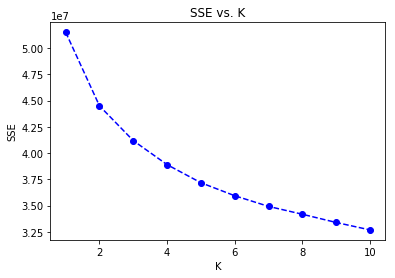

In [27]:
## sum of squared errors vs number of cluters plot
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K'); 

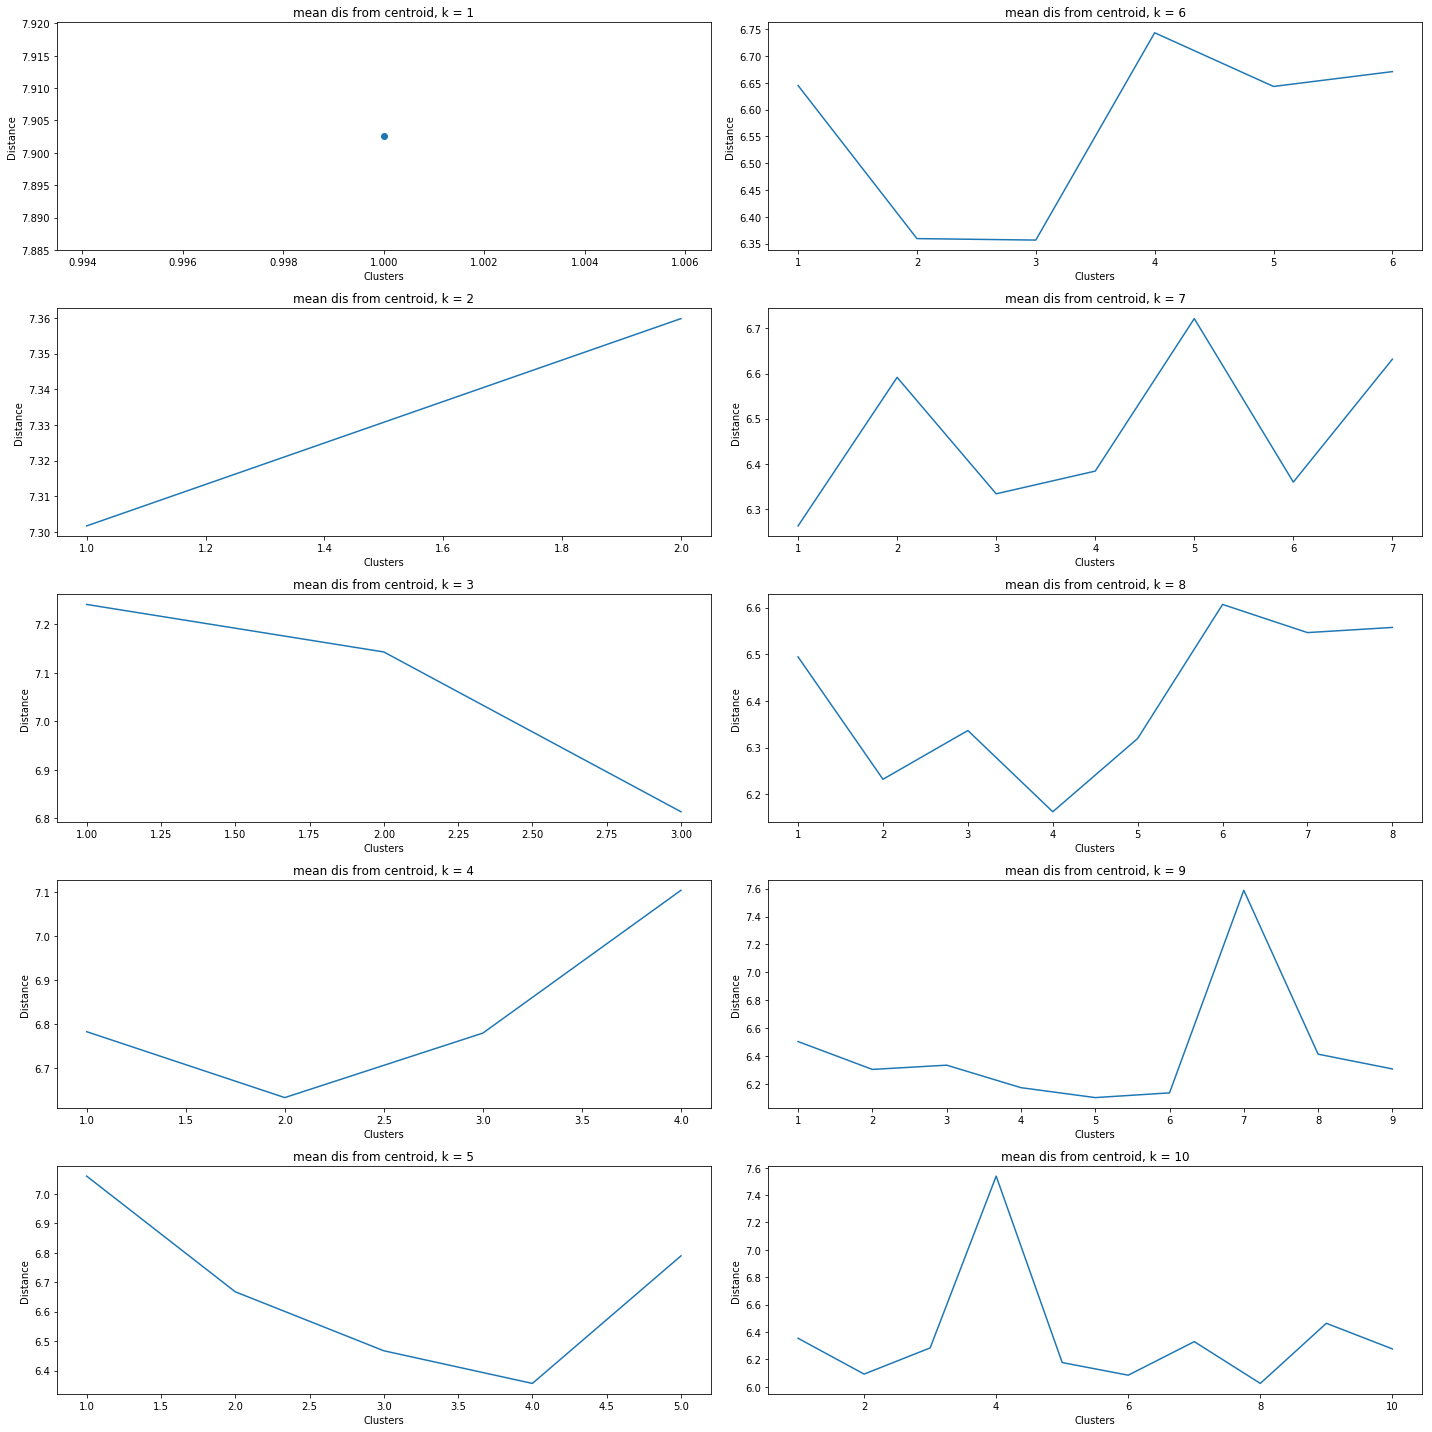

In [28]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
fig,axes=plt.subplots(5,2,figsize=(20,20))
count=0
count2=5
for ax_aux in axes:
    if count==0:
        ax_aux[0].scatter(centers[:len(means[count])],means[count])
    
    else:
        ax_aux[0].plot(centers[:len(means[count])],means[count])
        
    ax_aux[0].set_title("mean dis from centroid, k = "+str(count+1))
    ax_aux[0].set_xlabel('Clusters')
    ax_aux[0].set_ylabel('Distance')
    count=count+1

    ax_aux[1].plot(centers[:len(means[count2])],means[count2])
    ax_aux[1].set_title("mean dis from centroid, k = "+str(count2+1))
    ax_aux[1].set_xlabel('Clusters')
    ax_aux[1].set_ylabel('Distance')
    count2=count2+1
    
plt.tight_layout()
plt.show()

In [29]:
%%time
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

from sklearn.cluster import KMeans

def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return model,score


model,score = get_kmeans_score(azdias_reduced, 5)
km5 = model
azdias_reduced_clusters5 = km5.predict(azdias_reduced)

clusters_to_add =  pd.DataFrame(azdias_reduced_clusters5, columns = ['clusters'])
clusters_to_add.index=azdias_raw.index
azdias_raw=pd.concat([azdias_raw,clusters_to_add],axis=1)

CPU times: user 1min 2s, sys: 6.29 s, total: 1min 8s
Wall time: 1min 20s


### Discussion 3.1: Apply Clustering to General Population

I've selected 5 clusters based on the "Elbow Method", observed in the Sum of Squared Errors (SSE) versus number of clusters (K) Figure, and also based on the fact that from K=5 the mean distance between the data and respective centroids is in the range between 6.4 and 7.1, which is similar to the models with a higher K.

Finally, a lower number of clusters could allow us to interpret better the customers segments in the dataset (i.e. versus a higher number of clusters).


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [33]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')
len(customers)

191652

In [34]:
%%time
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
#from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from workspace_utils import active_session

with active_session():

    customers,customers_raw=clean_data(customers)
    customers['GEBAEUDETYP_5.0'] = 0
    customers_aux=imp.transform(customers)
    customers_complete=pd.DataFrame(customers_aux,index=customers.index, columns=customers.columns)
    #customers_complete=customers.dropna(axis=0)


    # Apply feature scaling to the general population demographics data.
    feat_info_ordinal=feat_info.loc[(feat_info.attribute.isin(customers_complete.columns)) & (feat_info.type=='ordinal')]
    feat_info_numeric=feat_info.loc[(feat_info.attribute.isin(customers_complete.columns)) & (feat_info.type=='numeric')]

    ordinal_columns_list=feat_info_ordinal.attribute.values
    numeric_columns_list=feat_info_numeric.attribute.values

    customers_complete_scaled = customers_complete.copy()

    columns_list=np.concatenate((numeric_columns_list,ordinal_columns_list,np.array(['decade','wealth','life_stage'])))

    # transform with previous scaler
    customers_aux=scaler.transform(customers_complete[columns_list])  

    customers_complete_scaled[columns_list] = customers_aux

    # transform with previous pca_small model.
    customer_pca_small = azdias_pca_model_small.transform(customers_complete_scaled)

    # finally obtain cluster predictions
    customer_clusters5 = km5.predict(customer_pca_small)
    
    clusters_to_add =  pd.DataFrame(customer_clusters5, columns = ['clusters'])
    clusters_to_add.index=customers_complete_scaled.index
    customers_raw=pd.concat([customers_raw,clusters_to_add],axis=1)

CPU times: user 7.49 s, sys: 1.27 s, total: 8.77 s
Wall time: 9.01 s


## Step 3.3: Compare Customer Data to Demographics Data
At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's countplot() or barplot() function could be handy.
- Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the .inverse_transform() method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

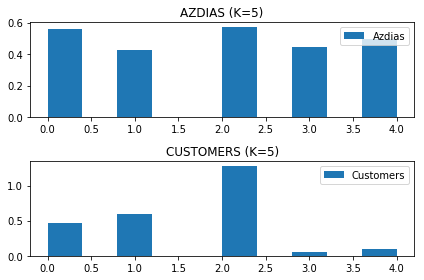

In [35]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

def get_histogram_clusters(azdias_clusters,customer_clusters,normed=True):

    fig,ax = plt.subplots(2,1)
    ax[0].hist(azdias_clusters,label='Azdias',normed=normed)
    ax[0].set_title('AZDIAS (K=5)')
    ax[0].legend()    
    ax[1].hist(customer_clusters,label='Customers',normed=normed)
    ax[1].set_title('CUSTOMERS (K=5)')
    ax[1].legend()    

    plt.tight_layout()
    plt.show()
    
get_histogram_clusters(azdias_reduced_clusters5,customer_clusters5,True)

In [36]:
customers_raw['clusters'].unique()

array([1, 0, 4, 2, 3])

In [37]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Cluster 3 is overrepresented in the customer data

customer_cluster_3=customers_raw[customers_raw['clusters']==2]

overrepresented_features=customer_cluster_3.median()


In [38]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Cluster 5 is underrepresented in the customer data

customer_cluster_5=customers_raw[customers_raw['clusters']==4]

underrepresented_features=customer_cluster_5.median()


In [39]:
final=pd.concat([overrepresented_features,underrepresented_features],axis=1)
#print(final)
print("feature:           over|under")
for index, row in final.iterrows():
    if (row[0]==row[1])==False:
        print("{:23s}|{}|{}<-------".format(index,row[0],row[1]))        
    else:
        print("{:23s}|{}|{}".format(index,row[0],row[1]))

feature:           over|under
ALTERSKATEGORIE_GROB   |4.0|2.0<-------
ANREDE_KZ              |1.0|1.0
CJT_GESAMTTYP          |3.0|4.0<-------
FINANZ_MINIMALIST      |5.0|4.0<-------
FINANZ_SPARER          |1.0|3.0<-------
FINANZ_VORSORGER       |5.0|3.0<-------
FINANZ_ANLEGER         |1.0|3.0<-------
FINANZ_UNAUFFAELLIGER  |2.0|4.0<-------
FINANZ_HAUSBAUER       |2.0|2.0
FINANZTYP              |5.0|3.0<-------
GFK_URLAUBERTYP        |7.0|8.0<-------
GREEN_AVANTGARDE       |1.0|0.0<-------
HEALTH_TYP             |2.0|2.0
LP_LEBENSPHASE_FEIN    |28.0|28.0
LP_FAMILIE_GROB        |4.0|4.0
LP_STATUS_GROB         |5.0|4.0<-------
NATIONALITAET_KZ       |1.0|1.0
PRAEGENDE_JUGENDJAHRE  |5.0|11.0<-------
RETOURTYP_BK_S         |5.0|3.0<-------
SEMIO_SOZ              |4.0|6.0<-------
SEMIO_FAM              |4.0|6.0<-------
SEMIO_REL              |3.0|6.0<-------
SEMIO_MAT              |3.0|5.0<-------
SEMIO_VERT             |6.0|6.0
SEMIO_LUST             |6.0|3.0<-------
SEMIO_ERL              

### Discussion 3.3: Compare Customer Data to Demographics Data

#### Segments of the population that are relatively popular with the mail-order company, 

Cluster 3 was deemed overrepresented in the customers dataset, therefore it represents a costumer 
segment that is popular with the mail order company. 
Using the median value of the features macthing to this cluster, we observe the following
characteristics for this customer segment: Older-adult women, living in or closer to urban area, 
established middleclass, no children, very high income, and with a high investor profile. 
These characteristics are derived from observing the list displayed next.

#####  Person-level features: 

- at or above 60 years old; 
- female; 
- Customer-Journey-Typology: preferred information and buying channels for consumer: advertisinginterested Store-shopper
- very high SPARER: money-saver
- not a pensionist;
- high investor financial profile
- member of environmental sustainability
- title  holder-households
- independents
- Individualisation
- LP_FAMILIE_GROB: multiperson household (maps to 9-11 in fine scale)
- determined Minimal-Returner
- average socially-minded
- MAT: materialistic - low
- VERT: dreamful - low
- LUST: sensual-minded - low
- dutiful
- family-shopper
- birthdate: 1950-01-01 to 1954-12-31
- 2 people in the house
- at least 1 with an academic title


##### 2. Household-level features
- very high income 
- no children

#####  Building-level features
- average neighborhood

#####  RR4 micro-cell features
-  3: CAMEO_DEUG_2015, established middleclass

#### 5. RR3 micro-cell features
-  Number of 1-2 family houses in the microcell - 2: average share of 1-2 family homes

#####  Postcode-level features
-  Distance to nearest urban center - 4: 30 -  40 km

#####  RR1 neighborhood features
- 2: Purchasing power in region: high
- 3: high online affinity 


####  Segments of the population that are unpopular with the mail-order company, 

Cluster 5 was one of the underrepresented examples in the customers dataset, therefore it represents a costumer 
segment deemed unpopular with the mail order company. 
Using the median value of the features macthing to this cluster, we observe the following
characteristics for this segment of the population: adult woman (30-45 years), leaving in a household with more than 2 people, very likely to have children, on a more rural or furthest from an urban centre (i.e. when compared with cluster 3); from a consumption-oriented middleclass and with a lower affinity to invest. This summary is based on the list displayed next:

#####  Person-level features

- 30 - 45 years old
- female
- Customer-Journey-Typology: preferred information and buying channels for consumer:- 4: advertisinginterested Online-shopper
- average SPARER: money-saver
- average pensionist
- average investor financial profile
- not a member of environmental sustainability
- houseowners
- LP_FAMILIE_GROB: family orientation
- incentive-receptive Normal-Returner
- not socially-minded
- MAT: materialistic - average
- VERT: dreamful - average
- LUST: sensual-minded - average- family-shopper
- not dutiful
- Shopping-stressed
- birthdate: 1975-01-01 to 1979-12-31
- 3 people in the house

##### 2. Household-level features
- high income 
- with children

##### Building-level features

- rural neighborhood

##### RR4 micro-cell features

- CAMEO_DEUG_2015, consumption-oriented middleclass

#### 5. RR3 micro-cell features
-  Number of 1-2 family houses in the microcell - 3: high share of 1-2 family homes

##### Postcode-level features
-  Distance to nearest urban center - 6: 50 - 100 km

##### RR1 neighborhood features
- 3: Purchasing power in region: high
- 4: very high online affinity 




## Summary:

Using and unsupervised learning pipeline consisting on dimensionality reduction via PCA and clustering of the selected features via K-means, it was possible to compare the customers data with the general population data. 
It was possible to observe differences in over- and under- represented customer clusters, i.e. when using a k-means model trained on the population data to predict the clusters on the customer data.

These differences, described above, are important for the company to plan appropriate marketing strategies to continue to reach out to their current customers (cluster 3), and perhaps also help to plan alternative strategies to capture those customer segments that are still "under-represented" (cluster 5) in the company. 


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.